# Surrogate Ensemble Modeling for Dynamic Climate Impact Models

Introduction

Libraries

In [55]:
import numpy as np
import pandas as pd

from utils import plotting

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Seaonal forecasts ensembles

### Malaria modeling

### Dataset

In [35]:
dataset = 'forecast and query loop clim and R0 2017-2021.csv'

In [36]:
df = pd.read_csv('datasets/'+dataset)
df.head()

,month,day,year,forecast,Precip_layer,Temp_layer,precip,temp,datetime,P,gono_len,sporo_len,mosquitoes,R0
0,1,1,2017,1,50686,50685,0.576628,17.865900,2017-01-01,0.904054,5.173293,1000.000000,0.000000,0.000000e+00
1,1,1,2018,1,50686,50685,0.166432,18.287195,2018-01-01,0.902434,4.983980,386.497216,0.576628,3.811930e-18
2,1,1,2019,1,50686,50685,1.760069,19.013910,2019-01-01,0.898305,4.694860,109.477182,0.891898,8.634740e-06
3,1,1,2020,1,50686,50685,0.000000,16.801691,2020-01-01,0.905616,5.742562,1000.000000,1.635573,1.264950e-43
4,1,1,2021,1,50686,50685,0.950271,17.495355,2021-01-01,0.905009,5.355321,1000.000000,2.106984,9.517402e-44


In [37]:
def preprocess(data):
    
    data['date'] = pd.to_datetime(data['datetime'])
    data['month'] = data['date'].dt.month.astype(int)
    data['day_of_month'] = data['date'].dt.day.astype(int)
    data['season'] = np.where(data['month'].between(1, 6),"Spring","Fall")
    
    #data = data[columns]

    return data

In [38]:
df = preprocess(df)
df.head()

,month,day,year,forecast,Precip_layer,Temp_layer,precip,temp,datetime,P,gono_len,sporo_len,mosquitoes,R0,date,day_of_month,season
0,1,1,2017,1,50686,50685,0.576628,17.865900,2017-01-01,0.904054,5.173293,1000.000000,0.000000,0.000000e+00,2017-01-01,1,Spring
1,1,1,2018,1,50686,50685,0.166432,18.287195,2018-01-01,0.902434,4.983980,386.497216,0.576628,3.811930e-18,2018-01-01,1,Spring
2,1,1,2019,1,50686,50685,1.760069,19.013910,2019-01-01,0.898305,4.694860,109.477182,0.891898,8.634740e-06,2019-01-01,1,Spring
3,1,1,2020,1,50686,50685,0.000000,16.801691,2020-01-01,0.905616,5.742562,1000.000000,1.635573,1.264950e-43,2020-01-01,1,Spring
4,1,1,2021,1,50686,50685,0.950271,17.495355,2021-01-01,0.905009,5.355321,1000.000000,2.106984,9.517402e-44,2021-01-01,1,Spring


### Surrogate training

In [84]:
split = "split-by-year"
train_years = [2017, 2018, 2019, 2020]
train_ensembles = 0.7

quantiles = [0.1587, 0.50, 0.8413]


"""
if split == "split-by-year":
    df1 = resample_df[resample_df['year'] <  2021].copy()
    df2 = resample_df[resample_df['year'] == 2021].copy()
elif split == "split-by-ensemble":
    train_split = 0.7
    members = data['forecast'].unique()
    train_idxs = members[:int(train_split*len(members))]
    test_idxs = members[int(train_split*len(members)):]
"""

'\nif split == "split-by-year":\n    df1 = resample_df[resample_df[\'year\'] <  2021].copy()\n    df2 = resample_df[resample_df[\'year\'] == 2021].copy()\nelif split == "split-by-ensemble":\n    train_split = 0.7\n    members = data[\'forecast\'].unique()\n    train_idxs = members[:int(train_split*len(members))]\n    test_idxs = members[int(train_split*len(members)):]\n'

In [8]:
from sklearn.preprocessing import StandardScaler

def scale_data(data, train_idxs, test_idxs, features, target):
    
    df_train = data[data['year'].isin(train_idxs)].copy()
    
    # Fit Scaler only on Training features
    feature_scaler = StandardScaler()
    feature_scaler.fit(df_train[features].values)
    # Fit Scaler only on Training target values
    target_scaler = StandardScaler()
    target_scaler.fit(df_train[target].values)

    # Transfom on both Training and Test data
    data_values = data[features].values.copy()
    data = data.drop(columns=(features))
    data = data.join(pd.DataFrame(feature_scaler.transform(data_values),
                                  columns=features))
    return data, feature_scaler, target_scaler

def select_sliding_data(data, member_idxs, features, target, sequence_length):
    X_list, y_list = [], []
    for iyear in data['year'].unique():
        data_yearly = data[data['year']==iyear].copy()
        for iseason in ['Spring', 'Fall']:
            data_seasonal = data_yearly[data_yearly['season']==iseason].copy()
            for idx in data['forecast'].unique():
                idata_X = data_seasonal[data_seasonal['forecast']==idx][features].values
                idata_y = data_seasonal[data_seasonal['forecast']==idx][target].values
                for ii in range(len(idata_X)):
                    if (ii + sequence_length) < len(idata_X):
                        X_list.append(idata_X[ii:ii+sequence_length, :])
                        y_list.append(idata_y[ii+sequence_length])
    return np.array(X_list), np.squeeze(np.array(y_list))

In [40]:
train_idxs = [2017, 2018, 2019, 2020]
test_idxs = [2021]

features = ['day_of_month', 'month', 'precip', 'temp'] #,'R0']
target   = ['R0']

df_scaled, feature_scaler, target_scaler = scale_data(df.copy(), train_idxs, test_idxs, features, target)
#df_scaled = df.copy()

sequence_length = 50

df_train_scaled = df_scaled[df_scaled['year'].isin(train_idxs)].copy()
df_test_scaled = df_scaled[df_scaled['year'].isin(test_idxs)].copy()

X_train, y_train = select_sliding_data(df_train_scaled, train_idxs, features, target, sequence_length)
X_test, y_test = select_sliding_data(df_test_scaled, test_idxs, features, target, sequence_length)

In [ ]:
df

## BLSTM

In [31]:
## Model training

from models.BLSTM import train_blstm

n_features = len(features)
output_length = 1
batch_size = 4096
n_epochs = 200
learning_rate = 0.01
n_experiments = 200
load_model = 'BLSTM_train2017-2020_predict2021_e200_t0-01_seq50_feat5_bs4096.pth'

y_pred = train_blstm(X_train, y_train, X_test, n_features, output_length, batch_size, n_epochs, learning_rate, sequence_length, n_experiments, target_scaler, save_model=True, load_model=load_model)

MONTE CARLO DROPOUT
1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200


In [67]:
# Calc quantiles
### Calculate quantiles
#quantiles = [0.1587, 0.50, 0.8413]
y_pred_R0_mean = y_pred.mean(axis=1).values
y_pred_R0_sigminus = y_pred.quantile(0.1587, axis=1).values
y_pred_R0_sigplus = y_pred.quantile(0.8413, axis=1).values

In [68]:
test_df = pd.DataFrame()
shift = 0
for iyear in test_idxs:
    data_yearly = df[df['year']==iyear].copy()
    for iseason in ['Spring', 'Fall']:
        data_seasonal = data_yearly[(data_yearly['season']==iseason)].copy()
        for iforecast in data_seasonal['forecast'].unique():
            idf = pd.DataFrame(data_seasonal[data_seasonal['forecast']==iforecast][['date', 'R0']].iloc[sequence_length:].copy())
            idf['forecast'] = iforecast
            idf['season'] = iseason
            idf['R0 mean'] = test_R0_mean[(iforecast-1)*len(idf)+shift:(iforecast)*len(idf)+shift]
            idf['R0 sigminus'] = test_R0_sigminus[(iforecast-1)*len(idf)+shift:(iforecast)*len(idf)+shift]
            idf['R0 sigplus'] = test_R0_sigplus[(iforecast-1)*len(idf)+shift:(iforecast)*len(idf)+shift]
            test_df = test_df.append(idf)
        shift = (iforecast)*len(idf)
        print(shift)

6550
6700


In [69]:
test_df = test_df.reset_index()
test_df = pd.concat([test_df, y_pred], axis=1)
test_df

,index,date,R0,forecast,season,R0 mean,R0 sigminus,R0 sigplus,R0_0,R0_1,...,R0_190,R0_191,R0_192,R0_193,R0_194,R0_195,R0_196,R0_197,R0_198,R0_199
0,254,2021-02-20,2.175977e-01,1,Spring,0.033335,0.023594,0.041680,0.033107,0.025566,...,0.036547,0.050222,0.013910,0.045974,0.033378,0.020568,0.034934,0.029026,0.025314,0.032725
1,259,2021-02-21,3.188942e-02,1,Spring,0.204590,0.160813,0.246121,0.146184,0.129716,...,0.134370,0.258707,0.233766,0.212040,0.326023,0.293676,0.295220,0.239235,0.155402,0.200215
2,264,2021-02-22,2.894879e-01,1,Spring,0.034608,0.025934,0.044581,0.026831,0.000486,...,0.023262,0.037863,0.043421,0.045141,0.043415,0.016731,0.025499,0.027654,0.027902,0.044685
3,269,2021-02-23,2.904540e-01,1,Spring,0.089025,0.069112,0.111818,0.072520,0.087731,...,0.058051,0.121535,0.080566,0.064977,0.057492,0.115163,0.124972,0.079650,0.089679,0.104987
4,274,2021-02-24,3.476634e-01,1,Spring,0.101245,0.076432,0.126873,0.058854,0.070652,...,0.080624,0.090768,0.095179,0.071160,0.103514,0.112790,0.136278,0.061201,0.089891,0.083746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13245,91279,2021-12-27,1.018973e-16,50,Fall,0.002071,-0.011221,0.014721,0.021538,0.024068,...,0.033297,-0.037221,0.000683,0.006090,-0.026908,-0.017164,0.003361,-0.001016,0.011556,0.001312
13246,91284,2021-12-28,2.613944e-05,50,Fall,0.001757,-0.010601,0.013811,-0.005816,-0.015875,...,0.005325,-0.022110,0.011726,0.001805,-0.003851,-0.017716,-0.003149,0.010354,0.005290,-0.019041
13247,91289,2021-12-29,1.349285e-03,50,Fall,0.002201,-0.011851,0.015517,-0.021883,0.007397,...,0.014832,0.011530,-0.028437,-0.008133,-0.002644,0.028634,-0.001929,0.020242,-0.026316,0.014994
13248,91294,2021-12-30,8.935732e-07,50,Fall,0.002117,-0.010637,0.015832,0.014790,0.011520,...,0.025120,0.006816,0.002225,-0.008330,0.009959,-0.022825,-0.013063,-0.010173,-0.006860,-0.001176


In [83]:
test_df.to_csv('trained_models/blstm_n-exp200_'+split+'.csv', index=False)

## RFQR

In [110]:
np.shape(X_train.reshape(len(X_train),-1))

(53050, 250)

In [112]:
np.shape(X_train)

(53050, 50, 5)

In [107]:
np.shape(y_train.flatten())

(53050,)

In [ ]:
from models.RFQR import train_rfqr

random_state=0
min_samples_split=10
n_estimators=1000
n_jobs=8
verbose=True

y_pred_rfqr = train_rfqr(X_train, y_train, X_test, random_state, min_samples_split, n_estimators, n_jobs, verbose=True, save_model=True, load_model='RFQR_train2017-2020_predict2021.joblib')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.6s finished


# Result visualization

              date variable     Value
0       2021-02-20     R0_0  0.033107
1       2021-02-21     R0_0  0.146184
2       2021-02-22     R0_0  0.026831
3       2021-02-23     R0_0  0.072520
4       2021-02-24     R0_0  0.058854
...            ...      ...       ...
2649995 2021-12-27   R0_199  0.001312
2649996 2021-12-28   R0_199 -0.019041
2649997 2021-12-29   R0_199  0.014994
2649998 2021-12-30   R0_199 -0.001176
2649999 2021-12-31   R0_199  0.013231

[2650000 rows x 3 columns]
0.7987924528301886


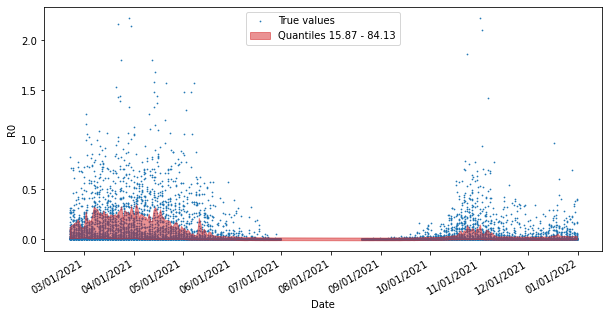

In [66]:
plotting.aggregate_ensembles_samples(test_df, 'figures/blstm_2021_agg_samples.pdf')

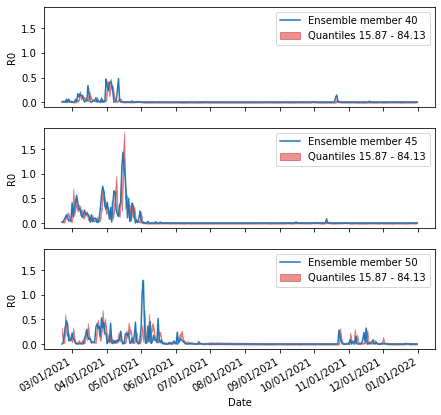

In [76]:
iforecasts = [40, 45, 50]
fig = plotting.plot_single_members(test_df, iforecasts, 'figures/blstm_2017-2021_iforecast.pdf')

In [74]:
plotting.hit_rate(test_df, 'R0', 'R0 sigplus', 'R0 sigminus')

0.686566037735849

In [22]:
filename = 'trained_models/BLSTM_train2017-2020_predict2021_e200_t0-01_seq50_feat5_bs4096_samples200_pm.csv'
df_blstm_big = pd.read_csv(filename)
df_blstm_big = df_blstm_big[df_blstm_big['source']=='Test']
df_blstm_big['date'] = pd.to_datetime(df_blstm_big['date'])
df_blstm_big

FileNotFoundError: [Errno 2] No such file or directory: '../trained_models/BLSTM_train2017-2020_predict2021_e200_t0-01_seq50_feat5_bs4096_samples200_pm.csv'

In [ ]:
# RFQR
# BIG DATASET
df1 = resample_df[resample_df['year'] <  2021].copy()
df2 = resample_df[resample_df['year'] == 2021].copy()

feature = ['day_of_month', 'month', 'precip', 'temp']
target = ['R0']
X_train = df1[feature].values
y_train = df1[target].values.flatten()
X_test = df2[feature].values
y_test = df2[target].values.flatten()

In [ ]:
# RFQR
# SMALL DATASET
train_split = 0.7
members = data['forecast'].unique()
train_idxs = members[:int(train_split*len(members))]
test_idxs = members[int(train_split*len(members)):]

df_train = data[data['forecast'].isin(train_idxs)].copy()
df_test = data[data['forecast'].isin(test_idxs)].copy()

X_train = df_train[features].values
y_train = df_train[target].values.flatten()
X_test = df_test[features].values
y_test = df_test[target].values.flatten()

In [41]:
from sklearn.preprocessing import StandardScaler

features = ['day_of_month', 'month', 'precip', 'temp', 'R0']
feature_array = df[features].values
scaled_array = df[features]
#feature_scaler = StandardScaler()
#scaled_array = pd.DataFrame(feature_scaler.fit_transform(feature_array),
#                            columns=features)
scaled_array.tail()

,day_of_month,month,precip,temp,R0
91295,31,12,0.000000,16.260675,4.107491e-43
91296,31,12,2.108539,19.631158,7.462358e-03
91297,31,12,23.831091,14.834802,3.704951e-46
91298,31,12,0.000000,21.807184,3.350008e-01
91299,31,12,6.121696,18.742517,3.184430e-06


In [42]:
import sys
# BLSTM
# BIG DATASET
def create_sliding_window(data, sequence_length, stride=1):
    X_list, y_list = [], []
    for i in range(len(data)):
        if (i + sequence_length) < len(data):
            print(data.iloc[i:i+sequence_length:stride, :])
            print(data.iloc[i+sequence_length, -1])
            sys.exit()
            X_list.append(data.iloc[i:i+sequence_length:stride, :].values)
            y_list.append(data.iloc[i+sequence_length, -1])
    return np.array(X_list), np.array(y_list)

train_split = 0.8
n_train = int(train_split * len(df))
n_test = len(df) - n_train

target_scaler = StandardScaler()
target_scaler.fit_transform(feature_array[:n_train, -1].reshape(-1, 1))

sequence_length = 50
X, y = create_sliding_window(scaled_array, 
                             sequence_length)
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

    day_of_month  month     precip       temp            R0
0              1      1   0.576628  17.865900  0.000000e+00
1              1      1   0.166432  18.287195  3.811930e-18
2              1      1   1.760069  19.013910  8.634740e-06
3              1      1   0.000000  16.801691  1.264950e-43
4              1      1   0.950271  17.495355  9.517402e-44
5              2      1   0.356005  17.834650  4.798062e-44
6              2      1   0.370689  17.492853  1.354475e-43
7              2      1   0.008628  19.696039  2.534957e-03
8              2      1   0.075067  15.714807  1.902339e-44
9              2      1   3.791583  18.313104  6.088486e-16
10             3      1   0.020057  16.931390  3.239143e-43
11             3      1   1.127198  19.028284  4.978712e-05
12             3      1   0.000000  18.738855  7.599307e-07
13             3      1   7.048789  17.210596  3.501503e-43
14             3      1   0.057016  18.063684  7.480023e-77
15             4      1   0.260736  16.8

SystemExit: 

/Users/juliankuehnert/.pyenv/versions/3.8.6/envs/ungana/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [43]:
df.iloc[50,:]

month                             1
day                              11
year                           2017
forecast                          1
Precip_layer                  50686
Temp_layer                    50685
precip                            0
temp                        18.0201
datetime                 2017-01-11
P                          0.903527
gono_len                    5.10193
sporo_len                   5512.65
mosquitoes                   9.4373
R0                     1.34941e-242
date            2017-01-11 00:00:00
day_of_month                     11
Name: 50, dtype: object

In [33]:
np.shape(X)

(91250, 50, 5)

In [34]:
np.shape(y)

(91250,)

In [ ]:
# BLSTM
# SMALL DATASET

### Random Forest Quantile Regression

### BLSTM

### Visu